This is a tutorial to use the flip package: https://github.com/corentinravoux/flip \
It is self-contained and can be used in google collab or on your environement \
All the data used are subsampled version of a simulation. \
The data size is small for the tutorial, do not use it for science case.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from flip import fitter, plot_utils, utils, data_vector, __flip_dir_path__
from flip.covariance import covariance, contraction

flip_base = Path(__flip_dir_path__)
data_path = flip_base / "data"
plt.style.use(data_path / "style.mplstyle")

[ 000000.00 ]: 06-11 08:19  root            INFO     No pypower module detected, gridding with this method is unavailable
/global/homes/r/ravouxco/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.6.0 is installed, but it is not compatible with the installed jaxlib version 0.6.1, so it will not be used.
  warnings.warn(


# Select data

In [2]:
# Density data
grid = pd.read_parquet(data_path / "density_data.parquet")
grid_window = pd.read_parquet(data_path / "grid_window_m.parquet")
coordinates_density = np.array([grid["ra"], grid["dec"], grid["rcom"]])
data_density = {'density': np.array(grid["density"]), 
                'density_error': np.array(grid["density_err"])}

DataDensity = data_vector.Dens(grid.rename(columns={'density_err': 'density_error', 'rcom': 'rcom_zobs'}).to_dict(orient='list'))


# Velocity data
sn_data = pd.read_parquet(data_path / "velocity_data.parquet")

coordinates_velocity = np.array([sn_data["ra"], sn_data["dec"], sn_data["rcom_zobs"]])
data_velocity = sn_data.to_dict("list")
for key in data_velocity.keys():
    data_velocity[key] = np.array(data_velocity[key])
data_velocity["velocity"] = data_velocity.pop("vpec")
data_velocity["velocity_error"] = np.zeros_like(data_velocity["velocity"])

data_velocity_true = {**sn_data.rename(columns={'vpec': 'velocity'}).to_dict(orient='list'), 
                      "velocity_error": np.zeros(len(sn_data["vpec"].values))}


# Create the True Vel data vector
DataTrueVel = data_vector.DirectVel(data_velocity_true)

# Create the Vel data vector
DataVel = data_vector.snia_vectors.VelFromSALTfit(sn_data.to_dict(orient='list'), velocity_estimator='full', h=0.7)

data_full = {}
data_full.update(data_density)
data_full.update(data_velocity)

DensTrueVel = data_vector.DensVel(DataDensity, DataTrueVel)


sigmau_fiducial = 15.0
sigmag_fiducial = 3.0

ktt, ptt = np.loadtxt(data_path / "power_spectrum_tt.txt")
kmt, pmt = np.loadtxt(data_path / "power_spectrum_mt.txt")
kmm, pmm = np.loadtxt(data_path / "power_spectrum_mm.txt")
power_spectrum_dict_bias = {"gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2]]}
power_spectrum_dict = {
    "gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2],[kmt, pmt * np.array(grid_window["window_mt"])],[ktt, ptt]],
    "gv": [[kmt, pmt * np.array(grid_window["window_mt"]) * utils.Du(kmt, sigmau_fiducial)],[ktt, ptt* utils.Du(kmt, sigmau_fiducial)]],
    "vv": [[ktt, ptt * utils.Du(ktt, sigmau_fiducial)**2]]
}

# Fit with true velocities

In [3]:
size_batch=500_000
number_worker=8

covariance_fit= DensTrueVel.compute_covariance(
                        "ravouxcarreres", 
                        power_spectrum_dict,
                        size_batch=size_batch, number_worker=number_worker, 
                        additional_parameters_values=(sigmag_fiducial,),
                        variant="nobeta")

[ 000009.75 ]: 06-11 08:19  root            INFO     Covariance matrix generated from flip with ravouxcarreres model in 9.63e+00 seconds


In [4]:
likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky", "use_jit":True}


parameter_dict = {"bs8": {"value": 1.0,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 100,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                 }


minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        DensTrueVel,
        parameter_dict,
        likelihood_type = likelihood_type,
        likelihood_properties = likelihood_properties
)

print('Free parameters are:', minuit_fitter.likelihood.free_par)

minuit_fitter.run()

Free parameters are: ['sigv', 'fs8', 'bs8']


[ 000082.45 ]: 06-11 08:21  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.54e+04                   │              Nfcn = 100              │
│ EDM = 2.97e-05 (Goal: 0.0001)    │           time = 72.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────

{'bs8': 0.9069700765013037,
 'fs8': 0.24828468906014098,
 'sigv': 215.6499239572814}

# Fit with estimated velocities

In [5]:
test_parameters = {"alpha":0.14,
                   "beta": 3.1,
                   "M_0": -19.133,
                   "sigma_M": 0.12}

velocity, velocity_error = DataVel(test_parameters)

mask = np.abs(velocity) < 3_000
mask &= np.sqrt(velocity_error) < 3_000

data_clean, _ = DataVel.get_masked_data_and_cov(mask)   


DataVelCleaned = data_vector.snia_vectors.VelFromSALTfit(data_clean, 
                                                         velocity_estimator='full', 
                                                         h=0.7)

DataDensVel = data_vector.DensVel(DataDensity, DataVelCleaned)

In [6]:
size_batch=500_000
number_worker=8

covariance_fit = DataDensVel.compute_covariance(
                        "ravouxcarreres", 
                        power_spectrum_dict,
                        size_batch=size_batch, number_worker=number_worker, 
                        additional_parameters_values=(sigmag_fiducial,),
                        variant="nobeta")

[ 000091.52 ]: 06-11 08:21  root            INFO     Covariance matrix generated from flip with ravouxcarreres model in 9.04e+00 seconds


In [7]:
likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky"}

parameter_dict = {"bs8": {"value": 1.0,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 100,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "alpha": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 0.25,
                          "fixed" : False,
                         },
                  "beta": {"value": 3.0,
                          "limit_low" : 2.5,
                          "limit_up" : 4.5,
                          "fixed" : False,
                         },
                  "M_0": {"value": -19,
                          "limit_low" : -21,
                          "limit_up" : -18,
                          "fixed" : False,
                         },
                  "sigma_M": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 100.0,
                          "fixed" : False,
                         },
                 }


minuit_fitter_velest = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        DataDensVel,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties)

print('Free parameters are:', minuit_fitter_velest.likelihood.free_par)

minuit_fitter_velest.run()

/global/homes/r/ravouxco/.local/perlmutter/python-3.11/lib/python3.11/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Free parameters are: ['alpha', 'beta', 'M_0', 'sigma_M', 'sigv', 'fs8', 'bs8']


[ 000250.70 ]: 06-11 08:23  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.617e+04                  │              Nfcn = 255              │
│ EDM = 6.6e-07 (Goal: 0.0001)     │           time = 158.7 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬────────

{'bs8': 0.7947312520609621,
 'fs8': 0.3127212223270973,
 'sigv': 450.6640789899744,
 'alpha': 0.128356507682582,
 'beta': 3.0221962007596197,
 'M_0': -19.098973995517003,
 'sigma_M': 0.09269802766031894}

# Some plots

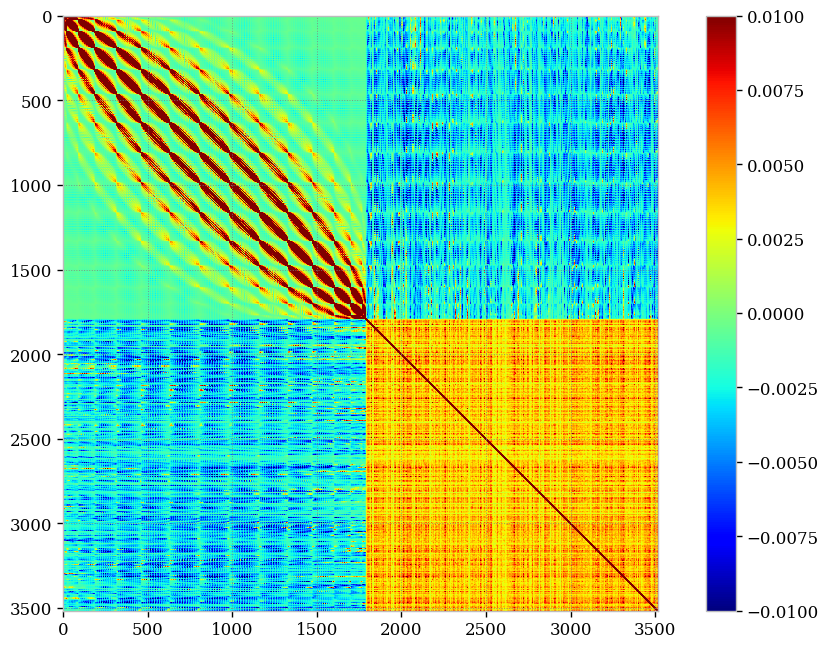

In [8]:
plot_utils.plot_correlation_from_likelihood(minuit_fitter_velest.likelihood,
                                            parameter_dict,
                                            vmin=-0.01,vmax=0.01)

In [9]:

r_perpendicular = np.linspace(-200,200,200)
r_parallel = np.linspace(-200,200,200)

r_reference_parallel = 30 
r_reference_perpendicular = 0 

contraction_plot = contraction.Contraction.init_from_flip(
    "adamsblake20",
    "full",
    power_spectrum_dict,
    r_perpendicular,
    r_parallel,
    r_reference_perpendicular,
    r_reference_parallel,
    coordinate_type="rprt",
    additional_parameters_values=(sigmag_fiducial,),
)

parameter_values_dict = {parameters: parameter_dict[parameters]["value"] for parameters in parameter_dict}

plot_utils.plot_2d_contraction(contraction_plot, 
                    parameter_values_dict, 
                    rs_multiplied = True)


KeyError: 'beta_f'